In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy.sparse import csr_matrix, vstack, hstack
import pickle
import catboost
import csv
from time import time
from tqdm import tqdm
from sklearn.metrics import precision_score, confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sn
import random

In [ ]:
#All the months for which the data is present
months = ['2015-01-28', '2015-02-28', '2015-03-28', '2015-04-28', '2015-05-28',
  '2015-06-28', '2015-07-28', '2015-08-28', '2015-09-28',
  '2015-10-28', '2015-11-28', '2015-12-28', '2016-01-28',
  '2016-02-28', '2016-03-28', '2016-04-28', '2016-05-28', '2016-06-28']
#Dictionary to map each month with a serial number
month_dict = dict(zip(months, np.arange(len(months))))

#Array of target columns
target_cols = np.array(['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
                       'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
                       'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
                       'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
                       'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
                       'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
                       'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
                       'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1'])

#Target columns or products
target_columns_english = ['savings_account', 'guarentees', 'current_account', 'derivative_account', 'payroll_account', 'junior_account', 'mas_account',
'perticular_account', 'perticular_plus', 'st_deposit', 'mt_deposits', 'lt_deposits', 'e_account', 'funds', 'mortgage',
 'pension', 'loan', 'tax', 'credit_card', 'securities', 'home_account', 'payroll', 'pension2', 'direct_debit']


#List of all the categorical columns
cat_columns = ['ind_empleado', 'sexo', 'ind_nuevo', 'indrel', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext',
                'indfall', 'tipodom', 'ind_actividad_cliente', 'segmento', 'pais_residencia', 'canal_entrada']
num_columns = ['age', 'renta', 'antiguedad'] #List of all numerical columns

In [ ]:
def process_cat_columns(data, col, train, doc):
  '''
  This function takes the value, column name, if its for training and a document to hold the value and its id (Encoding)
  Return the id corresponding to the value for that column (It does Label Encoding)
  returns 999 for all the new values that is absent in training data

  data : Value
  col : column name
  train : if its for training or testing
  doc : dictionary that holds value and its encoding
  '''
  data = data.strip() #This strips leading or tailing spaces
  if train: #If data is for training
    if data and data != 'NA': #If data is not null
      if data not in doc[col].keys(): #if data is not present in doc
        doc[col][data] = len(doc[col]) #Len(doc[col]) will always be one more than the maximum encoding already set
      return doc[col][data] #Returning the encoding
    else: #If the data is null
      if 'nan' not in doc[col].keys(): #if 'nan' is absent in doc
        doc[col]['nan'] = len(doc[col]) #Len(doc[col]) will always be one more than the maximum encoding already set
      return doc[col]['nan'] #Returning the encoding for nan
  else: #If data is not for training
    if data and data != 'NA': #If data is not null
      if data not in doc[col].keys(): #if data is not present in doc
        return 999 
      return doc[col][data] #if data is present in doc return corresponding encoding
    else: #If the data is null
      if 'nan' not in doc[col].keys(): #if 'nan' is absent in doc
        return 999
      return doc[col]['nan'] #Returning the encoding for nan


def process_num_columns(data):
  '''
  This function takes numerical column values 
  returns float value of the data for the data present
  returns -9999.0 if value is null or in [' NA', '     NA', '-999999', '         NA', '-9999999999']
  '''
  if data and data not in [' NA', '     NA', '-999999', '         NA', '-9999999999']: #If data is not null 
    return float(data) 
  else: #If data is null 
    return -9999.0


def getMonth(row):
  '''
  This function takes a row (dictionary of data of a row in dataset) 
  Returns the month of that purchase (row)

  row: dictionary of data of a row in dataset
  '''
  return int(row['fecha_dato'].split('-')[1]) #Splits the date and returns the month


def get_top_products(pred, test_prev_target):
  '''
  This function takes test_ids, prediction, previous target and training targets
  Returns top 7 recomendable products based on the prediction
  '''
  y_set = [i for i in range(24)] #Getting the set of all the targets in training dataset
  #pred = pred.toarray() #csr_array to np array
  for i in range(len(pred)): #For every test id
    for j, jdy in enumerate(y_set): #For every target in training target set
      if pred[i,j] <= test_prev_target[i][jdy]: #If the product is already purchased
        pred[i,j] = 0 #Set prediction to zero

  preds = np.argsort(pred, axis=1) #arg sorting the prediction
  preds = np.fliplr(preds)[:,:7] #selecting top 7 products

  return preds #Returning top 7 products

def get_purchased_products(train_data_loc, target_cols):
  '''
  This function takes data location and list of target column names
  Returns the products won by all the users

  train_data_file : Location of the csv file
  target_cols : List of target columns
  '''
  train_data_file = csv.DictReader(open(train_data_loc))

  purchased_products = {} #Dictionary to collect the products won by all the customers
  for row in tqdm(train_data_file):
    y = []
    for col in target_cols:
      c = row[col]
      if c and c != 'NA': # We append 0 if the value is missing or its 'NA'
        y.append(int(c))
      else:
        y.append(0)
    purchased_products[int(row['ncodpers'])] = y
  
  return purchased_products

def productids_names(pred, target_cols):
  '''
  This function takes the prediction and target columns 
  returns a string with names of predicted products

  pred : Array of predctions
  target_cols : Array of target columns
  '''
  return [" ".join(list(target_cols[p])) for p in pred]

def get_recomendations(recommendations, test_data_loc, filename):
  '''
  This function takes recomendation, test data location and file name 
  creates a csv file in the submission file format

  recommendations : list of recomendations
  test_data_loc : location of test data
  filename : Name of the submission file
  '''
  test_data_file = csv.DictReader(open(test_data_loc)) #Reading the test data
  test_ids = np.array([int(row['ncodpers']) for row in test_data_file]) #Get the user ids of customers in test data
  fields = ['ncodpers', 'added_products'] #Column names
  rows = np.vstack((test_ids, np.array(recommendations))).T #Creating an array of test ids and recomendations

  with open(filename, 'w') as csvfile: #Creating a csv file with given name
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(fields) #Writing column names tothe file
    csvwriter.writerows(rows) #Writing the rows to the file

  print(filename, 'is created')

In [ ]:
def check_exceptions(row):
  try:
    for col in num_columns:
      if col not in row.keys():
        raise ValueError(str(col)+' column is not present in dataset' )
      if type(row[col]) != str and type(row[col]) != int and type(row[col]) != float:
        raise TypeError('Value for '+str(col)+' should be either int, float or string, but it is '+str(type(row[col])))

    for col in cat_columns:
      if col not in row.keys():
        raise ValueError(str(col)+' column is not present in dataset' )
      if type(row[col]) != str and type(row[col]) != int and type(row[col]) != float:
        raise TypeError('Value for '+str(col)+' should be either int, float or string')
    
    if 'ncodpers' not in row.keys():
        raise ValueError('ncodpers column is not present in dataset' )
    if row['ncodpers'].isnumeric() == False:
      raise TypeError('Value for ncodpers should be a int')

    if 'fecha_dato' not in row.keys():
        raise ValueError('fecha_dato column is not present in dataset' )
    if type(row['fecha_dato']) != str:
      raise TypeError('Date column should be in string')

    date = row['fecha_dato'].split('-')
    if len(date) !=3:
      raise ValueError('Your date format is incorrect, correct format is "YYYY-MM-DD"' )
    if len(date[0]) != 4 and len(date[1]) != 2 and len(date[2]) != 2:
      raise ValueError('Your date format is incorrect, correct format is "YYYY-MM-DD"' )
    if date[0].isnumeric() == False and date[1].isnumeric() == False and date[1].isnumeric() == False:
      raise ValueError('Your date format is incorrect, correct format is "YYYY-MM-DD"' )

  except ValueError as e:
    print(e)
  except TypeError as e:
    print(e)
  except:
    print('unknown error occured')

In [ ]:
def data_processing(data_loc, test_data_loc, doc, lag, for_validation):
  '''
  This function takes training and test data locations, Months to train on, lag months and the testing month

  returns the preprocessed train and test data in csr matrix form 

  data_loc : training data location 
  test_data_loc : test data location 
  '''

  prev_target = {} #This holds the previous target of each user
  row_count, row_count_valid, row_count_test = 0, 0, 0 #Initializing the row counts
  matrix_row, matrix_col, matrix_data = [], [], [] #Initializing the train matrix
  matrix_row_valid, matrix_col_valid, matrix_data_valid = [], [], [] #Initializing the validation matrix
  matrix_row_test, matrix_col_test, matrix_data_test = [], [], [] #Initializing the test matrix
  y_var, y_var_valid = [],[] #initializing target variable of train and validation data
  previous_purchase_month = {} #This holds the month of previous purchase of each user
  test_prev_target = [] #This holds all the products each user holds at the end of training months
  test_id = [] #This holds the ids of test data
  test_month = 16
  lag_months = 5
  x_var, x_var_test = 0,0
  for col in cat_columns:
    if col not in doc.keys():
      doc[col] = {} #Initializing document for all the categorical columns
  if for_validation:
    data_file = open(data_loc) #opening the training file
    for row in csv.DictReader(data_file): #Reading the file
        check_exceptions(row) #This checks and raises exceptions
        if month_dict[row['fecha_dato']] == test_month:
          train = False #if its testing month keep train variable false
        else:
          train = True #if its training month keep train variable true

        if month_dict[row['fecha_dato']] >= test_month - lag_months: #If the month is in lag months of any training month
          
          y = [] #initializaing target variable for a row
          for col in target_cols: #processing the target cols (few target cols have str data)
            c = row[col]
            if c and c != 'NA':
              y.append(int(float(c)))
            else:
              y.append(0)
          y = np.array(y)

          last_purchase_month = 0
          for i in range(1,month_dict[row['fecha_dato']]+1):
            k = months[month_dict[row['fecha_dato']] - i]
            k1 = months[month_dict[row['fecha_dato']] - i-1]
            lg =  lag.get((int(row['ncodpers']), k), np.zeros(24)) - lag.get((int(row['ncodpers']), k1), np.zeros(24))
            if np.argwhere((lg)>0).sum() >0: #if user had purchased
              last_purchase_month = month_dict[row['fecha_dato']] - i
              break

          previous_lag = np.zeros(24)
          for i in range(1,month_dict[row['fecha_dato']]+1):
            k = months[month_dict[row['fecha_dato']] - i]
            lg = lag.get((int(row['ncodpers']), k), np.zeros(24))
            if (int(row['ncodpers']), k) in lag.keys():
              previous_lag = lag.get((int(row['ncodpers']), k), np.zeros(24))
              break
          target = (y - previous_lag) > 0 #target = product held this month - products held last month

          if target.sum() > 0: #if the customer has bought new product in the current month
            if month_dict[row['fecha_dato']] == test_month: #if the month in either training month or testing month
              col_count = 0 #initializing column count to zero
              
              row_cols = [] #initializing list to hold column numbers of current row
              row_values = [] #initializing list to hold values of columns of current row
              
              for col in num_columns: #for each numerical column
                v = process_num_columns(row[col]) #processing num columns
                if v != 0: #if value of col is non zero
                  row_cols.append(col_count) #appending column number
                  row_values.append(v) #appending col value
                col_count += 1 #moving to next column
              
              for col in cat_columns: #for each categorical column
                v = process_cat_columns(row[col], col, train, doc) #processing categorical columns
                if v != 0: #if value of col is non zero
                  row_cols.append(col_count) #appending column number
                  row_values.append(v) #appending col value
                col_count += 1 #moving to next column
              
              row_values.append(month_dict[row['fecha_dato']] % 12) #current month
              row_cols.append(col_count) #appending column number
              col_count += 1 #moving to next column

              row_values.append(month_dict[row['fecha_dato']] - last_purchase_month) #number months since last purchase
              row_cols.append(col_count) #appending column number
              col_count += 1 #moving to next column

              lag_columns = [] #initializing lag columns
              lag_values = []
              for i in range(1,lag_months+1): #for each lag month
                k = months[month_dict[row['fecha_dato']] - i] #lag month
                lg =  lag.get((int(row['ncodpers']), k), np.zeros(24)) #get the products held in lag month
                lag_columns += list(np.argwhere((lg)>0)[:,0]+ (i-1)*24 + col_count) #list products held in lag month
                lag_values.append(lg)

              lag_values = np.array(lag_values) #converting lag values into arrays
              col_count += lag_months*24 #increasing column count 

              row_cols += lag_columns #appending column numbers of lag columns
              row_values += [1]*len(lag_columns) #appending 1 for each lag column

              #Get products present in any of the past lags
              present_in_any_past_lag = list(np.argwhere((np.array(lag_values).sum(axis=0))>0)[:,0] + col_count)
              row_cols += present_in_any_past_lag #appending column numbers of lag columns
              row_values += [1]*len(present_in_any_past_lag) #appending 1 for each lag column
              col_count += 24
              
              #Get products present in all the past lags
              present_in_all_past_lag = list(np.argwhere((np.array(lag_values).sum(axis=0))==lag_months)[:,0] + col_count)
              row_cols += present_in_all_past_lag #appending column numbers of lag columns
              row_values += [1]*len(present_in_all_past_lag) #appending 1 for each lag column
              col_count += 24

              #Get products removed in any of the past lags
              removed_in_lag_months = list(np.argwhere(((lag_values[1:,:] - lag_values[:-1,:]) < 0).sum(axis=0)>0)[:,0] + col_count)
              row_cols += removed_in_lag_months #appending column numbers of lag columns
              row_values += [1]*len(removed_in_lag_months) #appending 1 for each lag column
              col_count += 24

              #Get products added in any of the past lags
              added_in_lag_months = list(np.argwhere(((lag_values[1:,:] - lag_values[:-1,:]) > 0).sum(axis=0)>0)[:,0] + col_count)
              row_cols += added_in_lag_months #appending column numbers of lag columns
              row_values += [1]*len(added_in_lag_months) #appending 1 for each lag column
              col_count += 24

              #Get products removed in last month
              removed_last_month = list(np.argwhere((lag_values[-1] - lag_values[-2]) <0)[:,0] + col_count)
              row_cols += removed_last_month #appending column numbers of lag columns
              row_values += [1]*len(removed_last_month) #appending 1 for each lag column
              col_count += 24

              #Get products added in last month
              added_last_month = list(np.argwhere((lag_values[-1] - lag_values[-2]) >0)[:,0] + col_count)
              row_cols += added_last_month #appending column numbers of lag columns
              row_values += [1]*len(added_last_month) #appending 1 for each lag column
              col_count += 24


              if train == True: #if its one of training month
                for ind, prod in enumerate(np.argwhere((target)>0)[:,0]): #columns where new product is purchased
                  matrix_col += row_cols #appending all the columns numbers
                  matrix_data += row_values #appending all the column values
                  matrix_row += [row_count]*len(row_cols) #appending row counts
                  y_var.append(prod) #appending target column
                  row_count+=1 #increasing row count
              else: #if its one of validation month
                for ind, prod in enumerate(np.argwhere((target)>0)[:,0]): #columns where new product is purchased
                  matrix_col_valid += row_cols #appending all the columns numbers
                  matrix_data_valid += row_values #appending all the column values
                  matrix_row_valid += [row_count_valid]*len(row_cols) #appending row counts
                  y_var_valid.append(prod) #appending target column
                  row_count_valid+=1 #increasing row count

          if target.sum() > 0: #if the customer has bought new product in the current month
            previous_purchase_month[int(row['ncodpers'])] = month_dict[row['fecha_dato']] #updating previous purchase month 
          prev_target[int(row['ncodpers'])] = list(y) #updating previous target
          lag[(int(row['ncodpers']), row['fecha_dato'])] = y #updating lag

    if len(matrix_data)>0:
      x_var = csr_matrix((matrix_data, (matrix_row,matrix_col))) #convering lists to csr matrix
    if test_month != 17: #if the test month is not june 2016
      x_var_test = csr_matrix((matrix_data_valid, (matrix_row_valid, matrix_col_valid))) #convering lists to csr matrix
    
    del matrix_data, matrix_row, matrix_col, matrix_data_valid, matrix_row_valid, matrix_col_valid #deleting lists from memory

  else: #if the test month is june 2016
    test_data_file = open(test_data_loc) #opening the testing file
    for row in csv.DictReader(test_data_file): #Reading the file
      check_exceptions(row) #This checks and raises exceptions
      test_id.append(int(row['ncodpers'])) #appending the customer id 
      col_count = 0 #initializing column count
      row_cols = [] #initializing list to hold column numbers of current row
      row_values = [] #initializing list to hold values of columns of current row

      for col in num_columns: #for each numerical column
        v = process_num_columns(row[col]) #processing num columns
        if v != 0: #if value of col is non zero
          row_cols.append(col_count) #appending column number
          row_values.append(v) #appending col value
        col_count += 1 #moving to next column
      
      for col in cat_columns: #for each categorical column
        v = process_cat_columns(row[col], col, False, doc) #processing categorical columns
        if v != 0: #if value of col is non zero
          row_cols.append(col_count) #appending column number
          row_values.append(v) #appending col value
        col_count += 1 #moving to next column

      row_values.append(month_dict[row['fecha_dato']] % 12) #current month
      row_cols.append(col_count) #appending column number
      col_count += 1 #moving to next column

      last_purchase_month = 0
      for i in range(1,month_dict[row['fecha_dato']]+1):
        k = months[month_dict[row['fecha_dato']] - i]
        k1 = months[month_dict[row['fecha_dato']] - i-1]
        lg =  lag.get((int(row['ncodpers']), k), np.zeros(24)) - lag.get((int(row['ncodpers']), k1), np.zeros(24))
        if np.argwhere((lg)>0).sum() >0: #if user had purchased
          last_purchase_month = month_dict[row['fecha_dato']] - i
          break

      previous_lag = np.zeros(24)
      for i in range(1,month_dict[row['fecha_dato']]+1):
        k = months[month_dict[row['fecha_dato']] - i]
        lg = lag.get((int(row['ncodpers']), k), np.zeros(24))
        if (int(row['ncodpers']), k) in lag.keys():
          previous_lag = lag.get((int(row['ncodpers']), k), np.zeros(24))
          break
      test_prev_target.append(previous_lag)

      row_values.append(month_dict[row['fecha_dato']] - last_purchase_month) #number months since last purchase
      row_cols.append(col_count) #appending column number
      col_count += 1 #moving to next column

      lag_columns = [] #initializing lag columns
      lag_values = []
      for i in range(1,lag_months+1): #for each lag month
        k = months[month_dict[row['fecha_dato']] - i] #lag month
        lg =  lag.get((int(row['ncodpers']), k), np.zeros(24)) #get the products held in lag month
        lag_columns += list(np.argwhere((lg)>0)[:,0]+ (i-1)*24 + col_count) #list products held in lag month
        lag_values.append(lg)

      lag_values = np.array(lag_values)
      col_count += lag_months*24

      row_cols += lag_columns #appending column numbers of lag columns
      row_values += [1]*len(lag_columns) #appending 1 for each lag column

      #Get products present in any of the past lags
      present_in_any_past_lag = list(np.argwhere((np.array(lag_values).sum(axis=0))>0)[:,0] + col_count)
      row_cols += present_in_any_past_lag #appending column numbers of lag columns
      row_values += [1]*len(present_in_any_past_lag) #appending 1 for each lag column
      col_count += 24

      #Get products present in all of the past lags
      present_in_all_past_lag = list(np.argwhere((np.array(lag_values).sum(axis=0))==lag_months)[:,0] + col_count)
      row_cols += present_in_all_past_lag #appending column numbers of lag columns
      row_values += [1]*len(present_in_all_past_lag) #appending 1 for each lag column
      col_count += 24

      #Get products removed in any of the past lags
      removed_in_lag_months = list(np.argwhere(((lag_values[1:,:] - lag_values[:-1,:]) < 0).sum(axis=0)>0)[:,0] + col_count)
      row_cols += removed_in_lag_months #appending column numbers of lag columns
      row_values += [1]*len(removed_in_lag_months) #appending 1 for each lag column
      col_count += 24

      #Get products added in any of the past lags
      added_in_lag_months = list(np.argwhere(((lag_values[1:,:] - lag_values[:-1,:]) > 0).sum(axis=0)>0)[:,0] + col_count)
      row_cols += added_in_lag_months #appending column numbers of lag columns
      row_values += [1]*len(added_in_lag_months) #appending 1 for each lag column
      col_count += 24

      #Get products removed in last month
      removed_last_month = list(np.argwhere((lag_values[-1] - lag_values[-2]) <0)[:,0] + col_count)
      row_cols += removed_last_month #appending column numbers of lag columns
      row_values += [1]*len(removed_last_month) #appending 1 for each lag column
      col_count += 24

      #Get products removed in last month
      added_last_month = list(np.argwhere((lag_values[-1] - lag_values[-2]) >0)[:,0] + col_count)
      row_cols += added_last_month #appending column numbers of lag columns
      row_values += [1]*len(added_last_month) #appending 1 for each lag column
      
      matrix_col_test += row_cols #appending all the columns numbers
      matrix_data_test += row_values #appending all the columns values
      matrix_row_test += [row_count_test]*len(row_cols) #appending row counts
      row_count_test+=1 #increasing row count

    x_var_test = csr_matrix((matrix_data_test, (matrix_row_test, matrix_col_test))) #convering lists to csr matrix

  del matrix_data_test, matrix_row_test, matrix_col_test #deleting lists from memory

  return x_var_test, y_var_valid, test_prev_target, test_id

In [ ]:
def plot_precision_matrix(y_var, pred):
  plt.figure(figsize=(9,5)) 
  cfm = confusion_matrix(y_var, pred, normalize='true')
  g = sn.heatmap(cfm, annot = True, cbar=False, cmap='Blues')

  for i in range(len(set(y_var))):
    g.add_patch(Rectangle((i, i), 1, 1, fill=False, edgecolor='black', lw=0.2))

  plt.xticks(np.arange(len(set(y_var))),np.array(target_columns_english)[list(set(y_var))])
  plt.xticks(rotation = 90)

  plt.yticks(np.arange(len(set(y_var))),np.array(target_columns_english)[list(set(y_var))])
  plt.yticks(rotation = 0)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.title('Precision Matrix')
  plt.show()

def plot_recall_matrix(y_var, pred):
  plt.figure(figsize=(9,5))
  cfm = confusion_matrix(y_var, pred, normalize='pred')
  g = sn.heatmap(cfm, annot = True, cbar=False, cmap='Blues')

  for i in range(len(set(y_var))):
    g.add_patch(Rectangle((i, i), 1, 1, fill=False, edgecolor='black', lw=0.2))

  plt.xticks(np.arange(len(set(y_var))),np.array(target_columns_english)[list(set(y_var))])
  plt.xticks(rotation = 90)

  plt.yticks(np.arange(len(set(y_var))),np.array(target_columns_english)[list(set(y_var))])
  plt.yticks(rotation = 0)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.title('Recall Matrix')
  plt.show()

In [ ]:
def final_fun_1(data, testdata, doc, lag, model):

  if type(data) == str:
    data_dict = csv.DictReader(open(data))
  if type(data) == csv.DictReader:
    data_dict = data
  x_var, y_var, prev_target, user_ids = data_processing(data_loc, testdata, doc, lag, for_validation=False) #Processing the data
  pred = model.predict_proba(x_var) #making the predictions
  recommendations = get_top_products(pred, prev_target) #getting top 7 products
  recommendations = productids_names(recommendations, target_cols) #Converting product ids to names
  recommendations = dict(zip(user_ids, recommendations)) #Zipping user ids and recommendations
  return recommendations

def final_fun_2(data, testdata, doc, lag, model):
  if type(data) == str:
    data_dict = csv.DictReader(open(data))
  if type(data) == csv.DictReader:
    data_dict = data
  x_var, y_var, prev_target, user_id= data_processing(data_loc, testdata, doc, lag, for_validation=True)#Processing the data
  h,w = x_var.shape
  x_var = np.hstack([x_var.toarray(), np.zeros(shape=(h,283-w))]) #asserting the shape
  pred = model.predict(x_var) #making prediction

  print('Micro precision score = '+ str(precision_score(y_var, pred, average='micro')))
  plot_precision_matrix(y_var, pred) #Plotting precision matrix
  print('-'*100)
  plot_recall_matrix(y_var, pred) #Plotting recall matrix

  return y_var, pred

In [ ]:
cb = catboost.CatBoostClassifier()
cb = cb.load_model('/content/drive/MyDrive/santander docs/cboost', format='cbm')
with open('/content/drive/MyDrive/santander docs/document', 'rb') as f:
    doc = pickle.load(f)
with open('/content/drive/MyDrive/santander docs/lag', 'rb') as f:
    lag = pickle.load(f)
data_loc = '/content/drive/MyDrive/santander docs/test1.csv'

In [ ]:
recommendations = final_fun_1(None, data_loc, doc, lag, cb)
random.choice(list(recommendations.items()))

(1207235,
 'ind_nomina_ult1 ind_nom_pens_ult1 ind_ecue_fin_ult1 ind_cco_fin_ult1 ind_reca_fin_ult1 ind_tjcr_fin_ult1 ind_valo_fin_ult1')

Micro precision score = 0.6


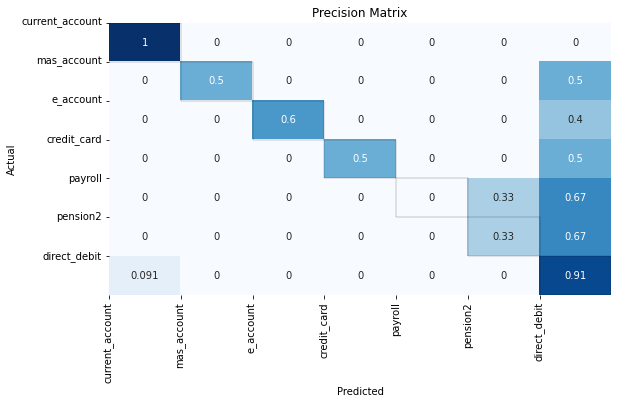

----------------------------------------------------------------------------------------------------


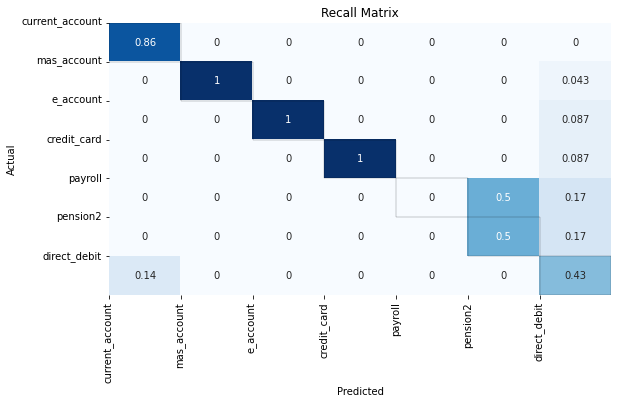

In [ ]:
y_matrix, pred = final_fun_2(data_loc, None, doc, lag, cb)